In [3]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from pyfuncs import *
sns.set_style("darkgrid")

from sklearn.preprocessing import StandardScaler  
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from astropy.io import fits
from astropy.table import Table
from IPython.display import display 
from pathlib import Path
import os
import PySimpleGUI as sg
import winsound, cellbell, joblib

# Read and prepare training data
Data is splitted into smaller batches and then standardised

In [2]:
# name of file of training data
filename = 'Test1.fits'

# format name (see astropy.Table documentation for more details)
f = 'fits'

# batch size
bsize = 10000

# number of batches
n = 2

dat = Table.read(filename, format=f)
df = dat.to_pandas()
if (n <= int(len(df)/bsize)) & (n > 0):
    dataset = np.empty(n, dtype=object)
    datasetX = np.empty(n, dtype=object)
    datasetY = np.empty(n, dtype=object)


    for i in range(n):
        dataset[i] = df[(np.array(range(len(df))) % n == i) & (df.index < (bsize*n))]
        dataset[i].reset_index(drop=True,inplace=True)
        datasetX[i] = pd.DataFrame(dataset[i][['dered_u','dered_g','dered_r','dered_i','dered_z']],columns = ['dered_u','dered_g','dered_r','dered_i','dered_z'])
        datasetY[i] = dataset[i]['z']
    print('Dataset has been splitted into', n, 'batches of', bsize, '.')
else:
    winsound.PlaySound("SystemHand", winsound.SND_ALIAS)
    print('ERROR!! - bsize*n > length of data loaded! Please decrease either n or bsize and try again.')

Dataset has been splitted into 2 batches of 10000 .


# Start training!
The code below will save your predicted data and MLP model in a local save file

In [94]:
%%ding
# change parameters for the regressor model here (see sklearn.mlpregressor documentation for details)
# "hidden layer size" parameter is listed further below as hddlsz 
mlp = MLPRegressor(activation='relu', solver='adam',batch_size='auto', random_state = 33)

# tperc is the percentage of data used for training (input should be a float between 0 and 1) 
# the rest is use for testing
tperc = 0.7

# number of random states used
rdnum = 1

# which predicted data file to read from (if file doesn't exist or left blank, a blank DataFrame is created instead)
# even if left blank, '' must be present
fread = 'Test1 results/NewData (relu, adam).json'

# which file to write to (if file doesn't exist, a file with same name will be created)
# DO NOT FORGET THE FILENAME EXTENSION ".json"!!
fwrite = 'Test1 results/NewData (relu, adam).json'

# name of folder to save all MLP models
mlpfolder = 'MLP models and scalers 1'

# list of hidden layer sizes. Each hidden layer size should be in the data type "tuple".
# multiple hidden layer sizes can be put together in a List so that the code runs through all of them
# i.e. [(1,1,1),(2,2),...]; for a single tuple, write [(20,20,20)]
hddlsz = [(10,10,10)]
#[(100,100,100),(100,100),(100),(50,50,50),(50,50),(50),(25,25,25),(25,25),(25),(10,10,10),(10,10),(10),(5,5,5),(5,5),(5)]


randst = mlp.random_state
try:
    mdata = pd.read_json(fwrite) 
except:
    event = 'Proceed'
else:
    if fread == fwrite:
        winsound.PlaySound("SystemHand", winsound.SND_ALIAS)
        event, values = sg.Window('WARNING',
                      [[sg.T('WARNING - fread = fwrite! Proceeding will add current data to ' + fread + '!')],
                      [sg.B('Proceed'), sg.B('Cancel') ]]).read(close=True)
    else:
        winsound.PlaySound("SystemHand", winsound.SND_ALIAS)
        event, values = sg.Window('WARNING',
                      [[sg.T('WARNING - ' + fwrite + ' already exist! Proceeding will overwrite the data in ' + fwrite + '!')],
                      [sg.B('Proceed'), sg.B('Cancel') ]]).read(close=True)

if (Path('Saved models and scalers/' + mlpfolder).is_dir() == True) & (event == 'Proceed'):
    winsound.PlaySound("SystemHand", winsound.SND_ALIAS)
    event1, values1 = sg.Window('WARNING',
                      [[sg.T('WARNING - ' + mlpfolder + ' already exist! Proceeding might overwrite all the files in ' + mlpfolder + '!')],
                      [sg.B('Proceed'), sg.B('Cancel') ]]).read(close=True)
else: 
    event1 = 'Proceed'
        
try:
    mdata = pd.read_json(fread)
except:
    mdata = pd.DataFrame()

if (event == 'Proceed') & (event1 == 'Proceed'):   
    lenX = len(datasetX)
    if (Path('Saved models and scalers').is_dir() == True):
        pass
    else: 
        os.mkdir('Saved models and scalers', mode=0o666)
    if Path('Saved models and scalers/' + mlpfolder).is_dir() == True:
        pass
    else:
        os.mkdir('Saved models and scalers/' + mlpfolder, mode=0o666)
    for x in hddlsz:
        mlp.hidden_layer_sizes = x
        for i in range(lenX):   
            scaler = StandardScaler()
            trainX, testX, trainY, testY = train_test_split(datasetX[i], datasetY[i],random_state=1, test_size=1-tperc)
            trainX = scaler.fit_transform(trainX)
            testX = scaler.transform(testX)
            filename = 'Saved models and scalers/' + mlpfolder + '/' + 'Scaler - ' + str(mlp.hidden_layer_sizes) + ', '\
            + mlp.solver + ', '+ mlp.activation + ', ' + 'dataset ' + str(i) + '.pkl'
            joblib.dump(scaler, filename)
            score = np.empty(rdnum,dtype=object)
            loss = np.empty(rdnum,dtype=object)
            ypredict = np.empty(rdnum,dtype=object)
            for k in range(rdnum):
                mlp.random_state = randst + k
                regr = mlp.fit(trainX,trainY)
                loss[k] = regr.loss_
                filename = 'Saved models and scalers/' + mlpfolder + '/' + 'MLP - ' + str(mlp.hidden_layer_sizes) + ', '\
                + mlp.solver + ', '+ mlp.activation + ', ' + 'dataset ' + str(i) + ', random state ' + str(mlp.random_state) + '.pkl'
                joblib.dump(regr, filename)
                score[k] = regr.score(testX,testY)
                ypredict[k] = regr.predict(testX)


            loss = loss[:,np.newaxis]
            score = score[:,np.newaxis]
            ypredict = ypredict[:,np.newaxis]
            comb = np.concatenate((score,loss,ypredict),axis=1)
            comb = pd.DataFrame(data = comb, columns = ['Score','Loss','ypredict'])
            comb['Hidden layer size'] = [mlp.hidden_layer_sizes]*rdnum
            comb['Random state'] = list(range(randst,mlp.random_state + 1))
            comb['Training data'] = ['dataset ' + str(i)]*rdnum
            comb['ytest data'] = [list(testY)]*rdnum
            mdata = mdata.append(comb, ignore_index = True)

    pd.DataFrame(mdata).to_json(fwrite)
    display(mdata)
else:
    print('Process has been stopped.')

,Score,Loss,ypredict,Hidden layer size,Random state,Training data,ytest data
0,-0.167231,0.000058,"[0.0187767731, 0.0179683595, 0.016457658, 0.01...","[100, 100, 100]",33,dataset 0,"[0.02363327, 0.01589246, 0.01808011, 0.0159781..."
1,0.023497,0.000056,"[0.017070977600000002, 0.0173385391, 0.0153690...","[100, 100, 100]",33,dataset 1,"[0.023634040000000002, 0.01589292, 0.01808074,..."
2,-14.04608,0.000239,"[0.01610815489788686, -0.0068655586955092, 0.0...","(10, 10, 10)",33,dataset 0,"[0.02363327, 0.01589246, 0.01808011, 0.0159781..."
3,-7.77835,0.000183,"[0.02080791205741983, 0.005174582942368278, 0....","(10, 10, 10)",33,dataset 1,"[0.02363404, 0.01589292, 0.01808074, 0.0159782..."


-25.929628612609807


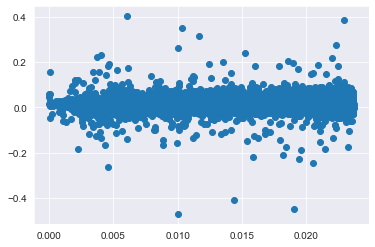

In [19]:
mlp = MLPRegressor(hidden_layer_sizes=(10,10,10),activation='relu', solver='adam',batch_size='auto', random_state = 33)
scaler = StandardScaler()
trainX, testX, trainY, testY = train_test_split(datasetX[1], datasetY[1],random_state=1, test_size=0.7)
trainX = scaler.fit_transform(trainX)
testX = scaler.transform(testX)
regr = mlp.fit(trainX,trainY)
print(regr.score(testX,testY))
plt.scatter(testY,mlp.predict(testX))

-0.3757544193974196


<function matplotlib.pyplot.show(close=None, block=None)>

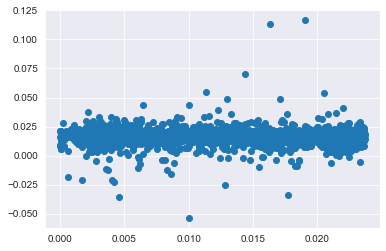

In [34]:
mlp = MLPRegressor(hidden_layer_sizes=(100,100,100),activation='relu', solver='adam',batch_size='auto', random_state = 33)
scaler = StandardScaler()
trainX = scaler.fit_transform(datasetX[0])
testX = scaler.fit_transform(datasetX[1])
regr = mlp.fit(datasetX[0],datasetY[0])
print(regr.score(datasetX[1],datasetY[1]))
plt.scatter(datasetY[1],mlp.predict(datasetX[1]))
plt.show

0.9869623392961744


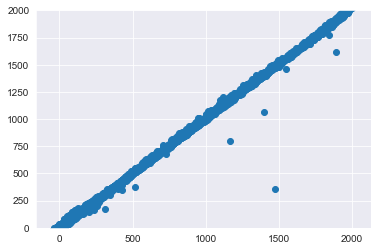

In [23]:
mlp = MLPRegressor(hidden_layer_sizes=(50,50,50),activation='relu', solver='adam',batch_size='auto', max_iter=500, random_state = 33)
scaler = StandardScaler()
x = np.random.rand(8000,5)*10
y = x[:,0]**2 - 3*x[:,1] + 2*x[:,2]**3 - x[:,4]/x[:,3] + np.random.rand(8000)*2
TRx, TSx, TRy, TSy = train_test_split(x, y,random_state=1, test_size=0.7)
TRx = scaler.fit_transform(TRx)
TSx = scaler.transform(TSx)
regr = mlp.fit(TRx,TRy)
print(regr.score(TSx,TSy))
pred = mlp.predict(TSx)
plt.scatter(pred,TSy)
plt.ylim(0,2000)
plt.show()

# Read file (.json file that is generated by the MLP above)

In [64]:
# name/path of file that will be read 
fread = 'Test1 results/NewData (relu, adam).json'

mdata = pd.read_json(fread)

# Plot histogram of each different hidden layer size configuration

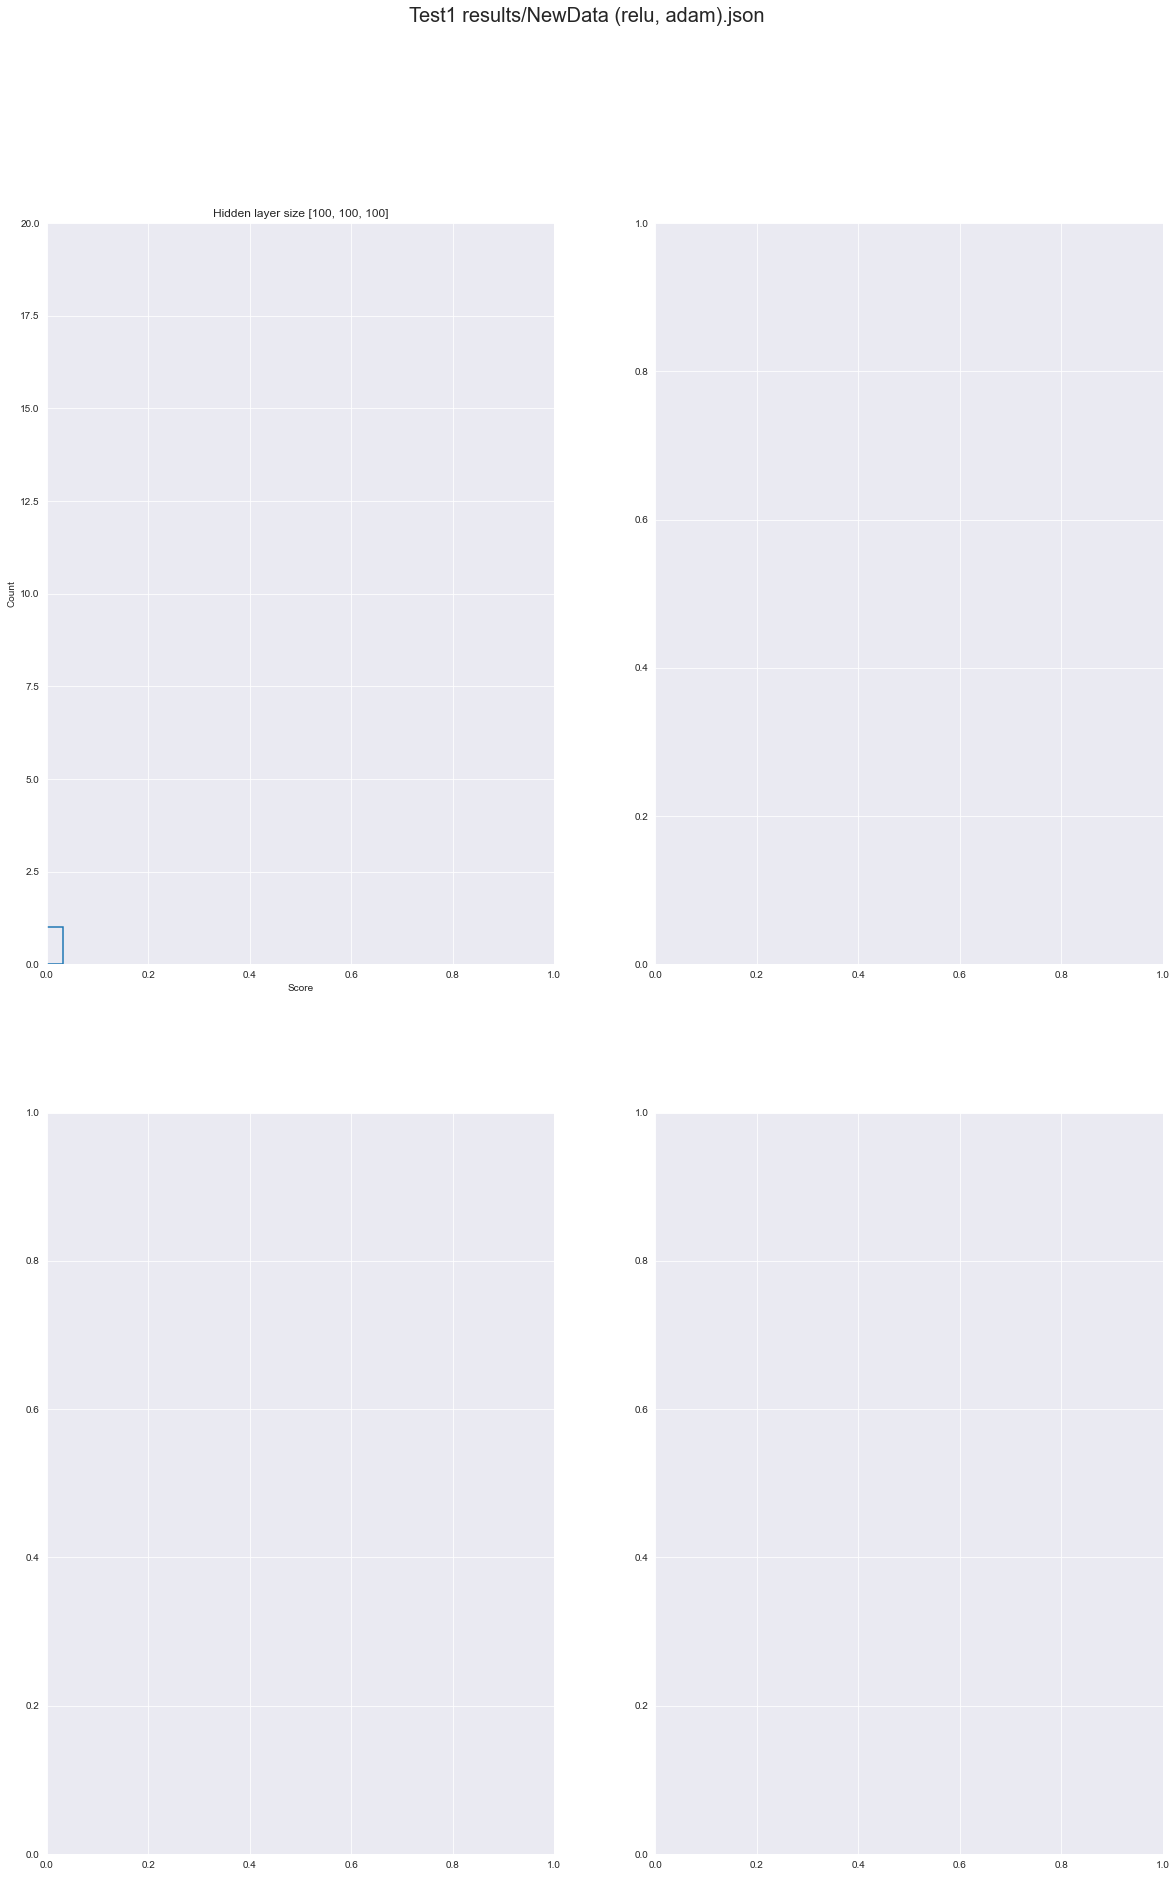

In [70]:
# size of subplot (row*column must be >= number of different hidden layer size configurations)
row = 2
column = 2

fig, ax = plt.subplots(row,column, figsize = (20,30))
fig.suptitle(fread, fontsize = 20) 
n = 0
a = sortHLS(mdata)
num = len(a)

for i in range(row):
    for j in range(column):
        if n < num:
            sns.histplot(data = mdata['Score'].loc[a[n]], binwidth = 0.05, fill = False, ax = ax[i,j])
            title = 'Hidden layer size ' + str(mdata['Hidden layer size'].loc[a[n][0]])
            ax[i,j].set_title(title)
            ax[i,j].set_label('Coefficient of determination')
            ax[i,j].set_ylim(0,20)
            ax[i,j].set_xlim(0,1)
            n = n + 1

plt.show()

# Mean score (coefficient of determination) of each hidden layer size configuration

In [92]:
a = sortHLS(mdata)
num = len(a)
Mean = pd.DataFrame()
for n in range(num):
    try:
        scr = list(mdata['Score'].loc[a[n]].mean())
        hls = list(mdata['Hidden layer size'].loc[a[n][0]])
    except:
        scr = [mdata['Score'].loc[a[n]].mean()]
        hls = [mdata['Hidden layer size'].loc[a[n][0]]]
    comb = pd.DataFrame({'Score':scr,'Hidden layer size':hls})
    Mean = Mean.append(comb,ignore_index=True)
display(Mean)

,Score,Hidden layer size
0,-0.071867,"[100, 100, 100]"


# Plot graph of predicted data VS sample data 

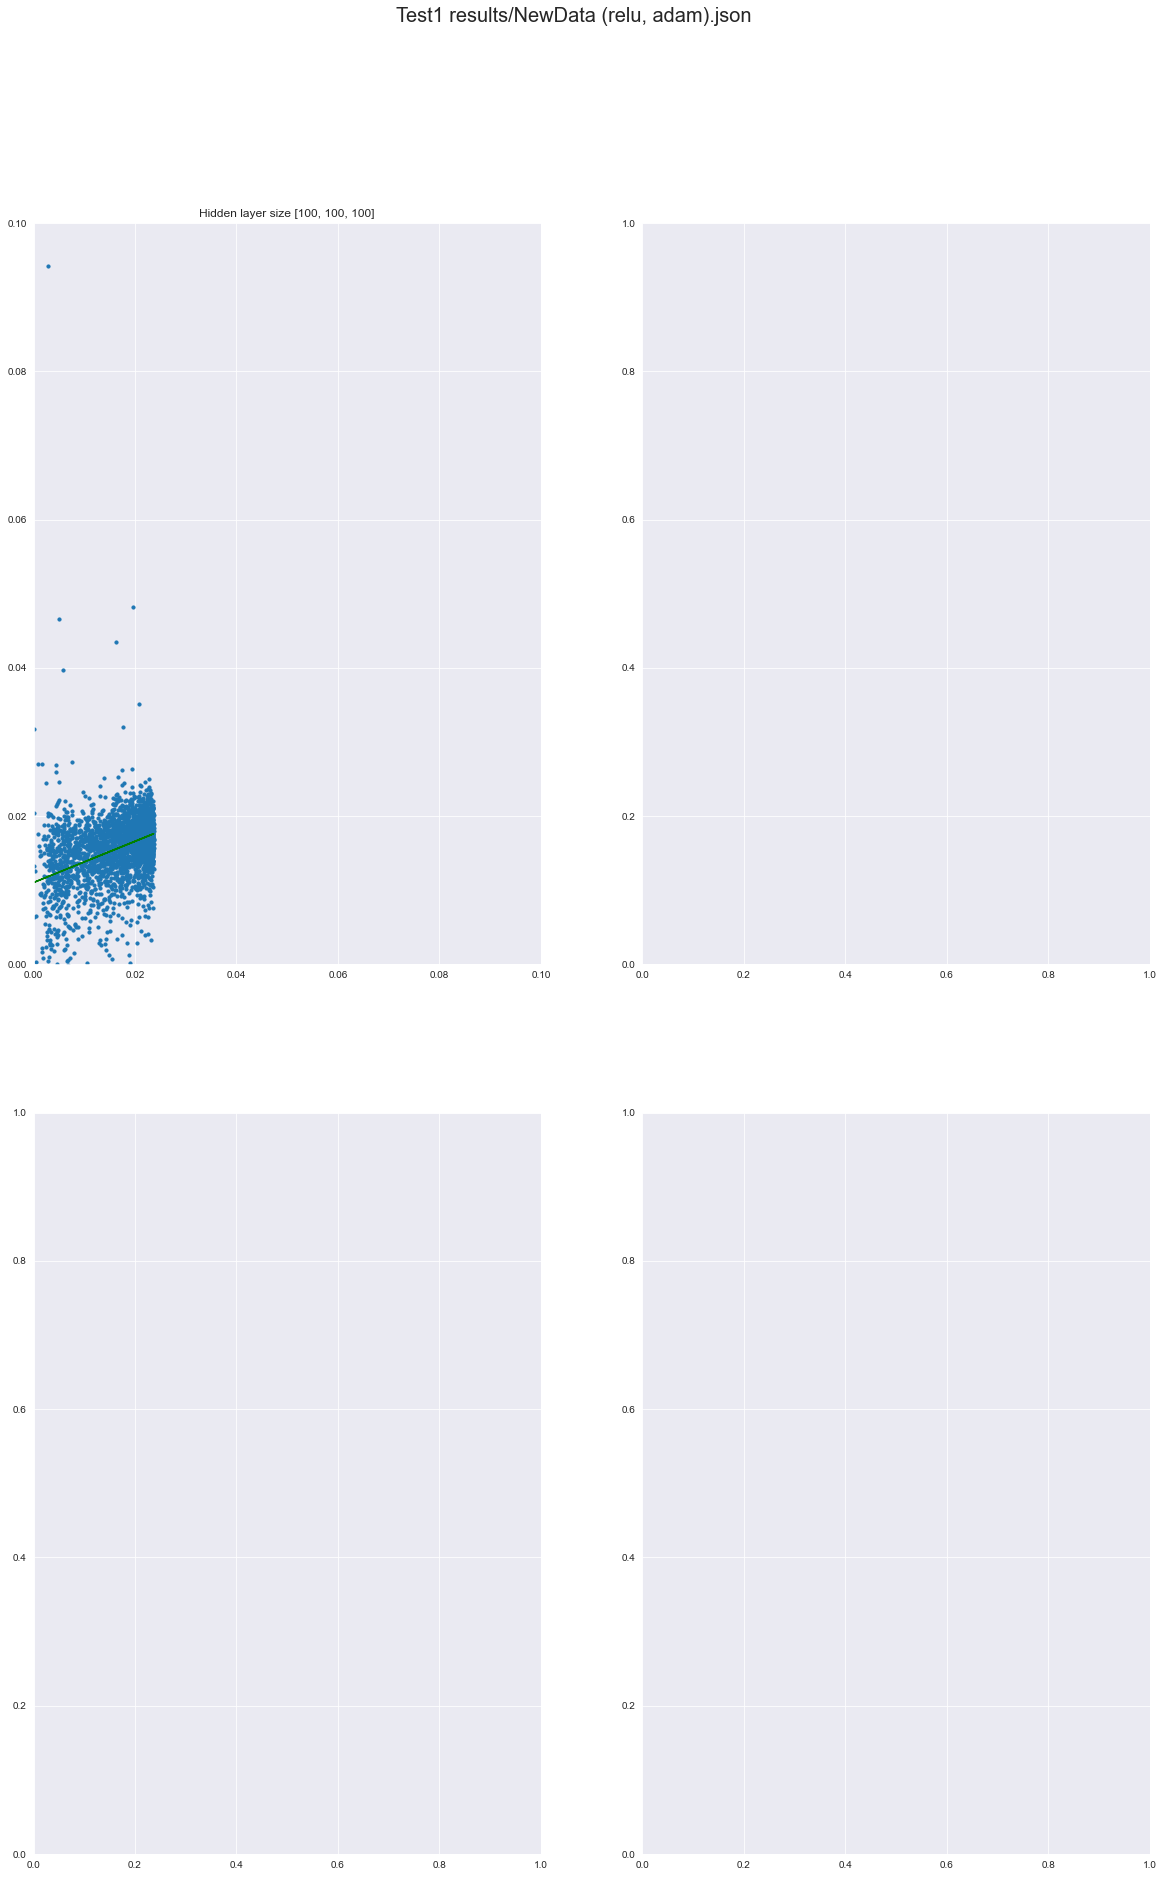

In [66]:
# size of subplot
row = 2
column = 2

# random state of mlp
rdst = 33

# training dataset of mlp
Tdata = 0

fig, ax = plt.subplots(row,column, figsize = (20,30))
fig.suptitle(fread, fontsize = 20)
n = 0
a = sortHLS(mdata)
num = len(a) 
crit = mdata[(mdata['Random state'] == rdst) & (mdata['Training data'] == ('dataset ' + str(Tdata)))] 
indx = crit.index

for i in range(row):
    for j in range(column):
        if n < num:
            ax[i,j].scatter(crit.loc[indx[n], 'ytest data'], crit.loc[indx[n], 'ypredict'], s = 10)
            m, b = np.polyfit(crit.loc[indx[n], 'ytest data'], crit.loc[indx[n], 'ypredict'], 1)
            ax[i,j].plot(crit.loc[indx[n], 'ytest data'], m * np.array(crit.loc[indx[n], 'ytest data']) + b, color = 'green')
            title = 'Hidden layer size ' + str(mdata['Hidden layer size'].loc[indx[n]])
            ax[i,j].set_title(title)
            ax[i,j].set_xlim(0,0.1)
            ax[i,j].set_ylim(0,0.1)
            n = n + 1
            
plt.show()

# Notes
## relu adam
performs better with more layers and nodes. Best performance could be seen in (100,100,100) with a score of ~0.75.
Worst performer is (5) with a score of ~0.50

## logistic adam
performs better with less layers and more nodes. Best performance could be seen in (100) with a score of ~0.60.
Worst performer is (5,5,5) with a score of ~0.23

## tanh adam
performs better with more layers and nodes. However, the top performers, (100,100,100), (50,50,50) and (25,25,25) performs almost equally well with a score of ~0.70. 
Worst performer is (5) with a score of ~-0.23

## relu sgd
performs better with more layers and nodes. However, overall perfomance is very very bad, with the best score being 0.38 and the worst being ~-1.07

## logistic sgd
performs better with less layers and more nodes. However, overall perfomance is bad, with the best score being ~0.39 and the worst being ~-0.07

## tanh sgd
performs better with more layers and nodes. However, overall performance is bad, with the best score being ~0.46 and the worst being ~-1.13